In [87]:
library(devtools)
library(ggridges)
library(gamlss)
library(gamlss.mx)
library(purrr)    # for map()
library(dplyr)    # optional; %>% + helpers
set.seed(1)

load_all("../../../hmmTMB")

ℹ Loading hmmTMB


In [99]:
## ------------------------------------------------------------------
## 1.  Observation-key  →  distribution name  (unchanged)
## ------------------------------------------------------------------
dists <- list(
  beta_obs       = "beta",
  binom_obs      = "binom",
  # cat_obs        = "cat3",
  dir_obs        = "dir",
  exp_obs        = "exp",
  foldednorm_obs = "foldednorm",
  gamma_obs      = "gamma",
  gamma2_obs     = "gamma2",
  lnorm_obs      = "lnorm",
  mvnorm_obs     = "mvnorm",
  nbinom_obs     = "nbinom",
  nbinom2_obs    = "nbinom2",
  norm_obs       = "norm",
  pois_obs       = "pois",
  t_obs          = "t",
  truncnorm_obs  = "truncnorm",
  tweedie_obs    = "tweedie",
  vm_obs         = "vm",
  weibull_obs    = "weibull",
  wrpcauchy_obs  = "wrpcauchy",
  zibinom_obs    = "zibinom",
  zigamma_obs    = "zigamma",
  zigamma2_obs   = "zigamma2",
  zinbinom_obs   = "zinbinom",
  zipois_obs     = "zipois",
  zoibeta_obs    = "zoibeta",
  ztnbinom_obs   = "ztnbinom",
  ztpois_obs     = "ztpois"
)

## ------------------------------------------------------------------
## 2.  Parameter sets  –- now TWO values per parameter (state 1, state 2)
## ------------------------------------------------------------------
params <- list(
  beta_obs       = list(shape1   = c( 2,  5),   shape2   = c( 5, 2)),
  binom_obs      = list(size     = c(10, 20),   prob     = c(0.50, 0.30)),
  # cat_obs        = list(p1       = c(0.30, 0.10), p2 = c(0.50, 0.60)),
  dir_obs        = list(alpha1   = c( 2,  5),   alpha2   = c( 3, 1)),
  exp_obs        = list(rate     = c( 1,  3)),
  foldednorm_obs = list(mean     = c( 0,  1),   sd       = c(1, 2)),
  gamma_obs      = list(shape    = c( 2,  5),   scale    = c(1, 2)),
  gamma2_obs     = list(mean     = c( 2,  5),   sd       = c(1, 2)),
  lnorm_obs      = list(meanlog  = c( 0,  1),   sdlog    = c(1, 0.5)),
  mvnorm_obs     = list(mu1      = c( 0,  1),   mu2      = c( 0, 0.5),
                        sd1      = c( 1,  2),   sd2      = c(1, 1),
                        corr12   = c( 0,  0)),
  nbinom_obs     = list(size     = c(10, 20),   prob     = c(0.50, 0.30)),
  nbinom2_obs    = list(mean     = c(10, 20),   shape    = c(1, 3)),
  norm_obs       = list(mean     = c( 0,  3),   sd       = c(1, 2)),
  pois_obs       = list(rate     = c( 2,  7)),
  t_obs          = list(mean     = c( 0,  2),   scale    = c(1, 3)),
  truncnorm_obs  = list(mean     = c(-1,  2),   sd       = c(1, 2),
                        min      = c(-2,  0),   max      = c(1, 3)),
  tweedie_obs    = list(mean     = c( 5,  10),  p        = c(0.8, 0.5),
                        phi      = c( 1,  2)),
  vm_obs         = list(mu       = c( 0,  1),   kappa    = c(2, 5)),
  weibull_obs    = list(shape    = c( 2,  1),   scale    = c(1, 3)),
  wrpcauchy_obs  = list(mu       = c( 0,  2),   rho      = c(0.7, 0.4)),
  zibinom_obs    = list(size     = c(10, 20),   prob     = c(0.50, 0.30),
                        z        = c(0.20, 0.10)),
  zigamma_obs    = list(shape    = c( 2,  5),   scale    = c(1, 2),
                        z        = c(0.20, 0.10)),
  zigamma2_obs   = list(mean     = c( 2,  5),   sd       = c(1, 2),
                        z        = c(0.20, 0.10)),
  zinbinom_obs   = list(size     = c(10, 20),   prob     = c(0.50, 0.30),
                        z        = c(0.20, 0.10)),
  zipois_obs     = list(rate     = c( 2,  7),   z        = c(0.20, 0.10)),
  zoibeta_obs    = list(shape1   = c( 2,  5),   shape2   = c(5, 2),
                        zeromass = c(0.10, 0.20), onemass = c(0.10, 0.05)),
  ztnbinom_obs   = list(size     = c(10, 20),   prob     = c(0.50, 0.30)),
  ztpois_obs     = list(rate     = c( 2,  7))
)

## ------------------------------------------------------------------
## 3.  Evaluation grids  (Linear arrays appart from dir and mvnorm which are matrices)
## ------------------------------------------------------------------
evaluation_vals <- list(
  beta_obs       = seq(0.05, 0.995, by = 0.01),               # was seq(0,   1,    0.01)
  binom_obs      = 0:10,
  # cat_obs        = 1:3,
  dir_obs        = sapply(seq(0.005, 0.995, by = 0.01),          # was seq(0,   1,    0.05)
                          function(x) c(x, 1 - x)),
  exp_obs        = seq(0.05, 3, by = 0.10),
  foldednorm_obs = seq(0.05, 5, by = 0.10),
  gamma_obs      = seq(0.05, 10, by = 0.10),
  gamma2_obs     = seq(0.05, 10, by = 0.10),
  lnorm_obs      = seq(0.01, 10, by = 0.10),
  mvnorm_obs     = t(as.matrix(expand.grid(seq(-3,3,0.2), seq(-3,3,0.2)))),
  nbinom_obs     = 0:30,
  nbinom2_obs    = 0:30,
  norm_obs       = seq(-3, 3, by = 0.10),
  pois_obs       = 0:20,
  t_obs          = seq(-5, 5, by = 0.10),
  truncnorm_obs  = seq(-1.975, 2.975, by = 0.15),              # was seq(-2,  3,   0.05)
  tweedie_obs    = seq(0, 2, by = 0.05),
  vm_obs         = seq(-pi, pi, length.out = 100),
  weibull_obs    = seq(0.05, 10, by = 0.10),
  wrpcauchy_obs  = seq(-pi, pi, length.out = 100),
  zibinom_obs    = 0:10,
  zigamma_obs    = seq(0, 5, by = 0.1),
  zigamma2_obs   = seq(0, 5, by = 0.1),
  zinbinom_obs   = 0:30,
  zipois_obs     = 0:20,
  zoibeta_obs    = seq(0, 1, by = 0.01),               # was seq(0.01,0.99,0.01)
  ztnbinom_obs   = 0:30,
  ztpois_obs     = 0:20
)

full_params <- list(dists = dists, params = params, evaluation_vals = evaluation_vals)
saveRDS(full_params, file = "../../tests/testthat/data/full_params.rds")
full_params <- readRDS("../../tests/testthat/data/full_params.rds")

In [100]:

n_training <- 2
training_df <- data.frame(
  ID = rep(1, n_training),
  matrix(rep(NA, n_training * length(dists)), nrow = n_training, dimnames = list(NULL, names(dists)))
)
training_df$mvnorm_obs <- I(replicate(n_training, c(NA, NA), simplify = FALSE))

tpm <- matrix(c(0.15, 0.9, 0.85, 0.1), 2, 2)
starting_state <- c(0.9, 0.1)
# crafted such that hidden state at n=1 = (0.225 0.775)
# and hidden state at n=2 = (0.73125 0.26875)

## Create True Model ----------------------------------------------------
hid_mod <- MarkovChain$new(
  data = training_df,
  n_states = 2,
  tpm = tpm
)
hid_mod$update_delta0(starting_state)
obs_mod <- Observation$new(
  data = training_df,
  n_states = 2,
  dists = dists,
  par = params
)
true_mod <- HMM$new(obs = obs_mod, hid = hid_mod)

In [101]:
n_forecast <- 2
forecast_df <- data.frame(
  ID = rep(1, n_forecast),
  matrix(rep(NA, n_forecast * length(dists)), nrow = n_forecast, dimnames = list(NULL, names(dists)))
)
forecast_df$mvnorm_obs <- I(replicate(n_forecast, c(NA, NA), simplify = FALSE))

forecast <- Forecast$new(
  hmm = true_mod,
  forecast_data = forecast_df,
  preset_eval_range = evaluation_vals,
  starting_state_distribution = starting_state %*% tpm,
)

In [5]:
# Simulate from the true model ------------------------------------------
n_simulations <- 10000 # Warning: Takes ~1 minutes per 100 simulations (~2hrs for 10,000)

# Initialize a named list of 2D arrays to store the simulation results
simulated_runs <- list()
for (obs in names(dists)) {
  simulated_runs[[obs]] <- matrix(
    vector("list", n_simulations * n_forecast),
    nrow = n_simulations, ncol = n_forecast
  )
}

true_mod$hid()$update_delta0(starting_state %*% tpm)

# Simulate data and store it in the array
for (i in 1:n_simulations) {
  sim <- true_mod$simulate(n = n_forecast, data = forecast_df, silent = TRUE)

  for (obs in names(dists)) {
    simulated_runs[[obs]][i, ] <- sim[[obs]]
  }
  if (i %% 100 == 0) {
    message(sprintf("Completed %d simulations", i))
    saveRDS(simulated_runs, file = "../../tests/testthat/data/simulated_runs.rds")
  }
}
saveRDS(simulated_runs, file = "../../tests/testthat/data/simulated_runs.rds")


In [102]:
simulated_runs <- readRDS("../../tests/testthat/data/simulated_runs.rds")

In [103]:
dist_class <- list(
  discrete           = c("binom_obs", "pois_obs", "nbinom_obs", "nbinom2_obs",
                          "zibinom_obs", "zinbinom_obs", "zipois_obs",
                          "ztnbinom_obs", "ztpois_obs"),
  zero_inflated      = c("zigamma_obs", "zigamma2_obs"),
  zero_one_inflated  = c("zoibeta_obs")
)

is_discrete          <- function(x) x %in% dist_class$discrete
is_zero_inflated     <- function(x) x %in% dist_class$zero_inflated
is_zero_one_inflated <- function(x) x %in% dist_class$zero_one_inflated

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# 1.  Density helpers
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# --- 1a. Discrete PMF -------------------------------------------------------

discrete_pdf <- function(sample_mat, eval_range) {
  apply(sample_mat, 2, function(col) {
    col <- as.numeric(col)
    counts <- table(factor(col, levels = eval_range))
    as.numeric(counts) / length(col)
  })
}

# --- 1b. Simple KDE ---------------------------------------------------------

kde_simple <- function(x, eval_range, bw) {
  x <- as.numeric(x)
  dens <- density(x,
                  from   = min(eval_range),
                  to     = max(eval_range),
                  n      = length(eval_range),
                  bw     = bw,
                  cut    = 0,
                  kernel = "gaussian")
  dens$y
}

# --- 1c. Zero‑inflated on [0, ∞) -------------------------------------------

zi_pdf <- function(sample_mat, eval_range, bw) {
  n_eval     <- length(eval_range)
  inner_vals <- eval_range[-1]

  apply(sample_mat, 2, function(col) {
    col   <- as.numeric(col)
    prob0 <- mean(col == 0)
    cont  <- col[col > 0]
    dens_y <- kde_simple(cont, inner_vals, bw)
    c(prob0, dens_y * (1 - prob0))
  })
}

# --- 1d. Zero‑one‑inflated on (0,1) ----------------------------------------

zoi_pdf <- function(sample_mat, eval_range, bw) {
  n_eval     <- length(eval_range)
  inner_vals <- eval_range[-c(1, n_eval)]

  apply(sample_mat, 2, function(col) {
    col <- as.numeric(col)
    prob0 <- mean(col == 0); prob1 <- mean(col == 1)
    cont  <- col[col > 0 & col < 1]
    dens_y <- kde_simple(cont, inner_vals, bw)
    c(prob0, dens_y * (1 - prob0 - prob1), prob1)
  })
}

# --- 1e. Plain KDE ----------------------------------------------------------

kde_pdf <- function(sample_mat, eval_range, bw) {
  apply(sample_mat, 2, function(col) {
    col <- as.numeric(col)
    kde_simple(col, eval_range, bw)
  })
}

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# 2.  Wrapper for one observation family
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

build_pdf <- function(obs_name) {
  multi_var  <- is.matrix(evaluation_vals[[obs_name]])
  eval_range <- if (multi_var) unique(evaluation_vals[[obs_name]][1, ])
                else            evaluation_vals[[obs_name]]
  bw         <- diff(eval_range)[1]

  sim_mat <- simulated_runs[[obs_name]]
  if (multi_var) sim_mat <- apply(sim_mat, c(1, 2), function(x) x[[1]])

  if (is_discrete(obs_name))          return(discrete_pdf(sim_mat, eval_range))
  if (is_zero_inflated(obs_name))     return(zi_pdf(sim_mat, eval_range, bw))
  if (is_zero_one_inflated(obs_name)) return(zoi_pdf(sim_mat, eval_range, bw))
  kde_pdf(sim_mat, eval_range, bw)
}

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# 3.  Build PDFs for all distributions
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

simulated_pdfs <- vector("list", length(dists))
names(simulated_pdfs) <- names(dists)
for (obs in names(dists)) {
  simulated_pdfs[[obs]] <- build_pdf(obs)
}


In [104]:
saveRDS(simulated_pdfs, file = "../../tests/testthat/data/simulated_pdfs.rds")
# simulated_pdfs <- readRDS("../../tests/testthat/data/simulated_pdfs.rds")

In [96]:
forecast_dists <- list()
# Get PDF at bin centers instead of edges
for (obs in names(dists)) {

  # if (obs %in% c("mvnorm_obs")) {
  #   # Extract only the first column of the multivariate distribution
  #   eval_range <- forecast$eval_range()[[obs]][1, ]
  #   eval_length <- length(unique(eval_range))
  #   multivar_pdf <- apply(
  #     array(forecast$forecast_dists()[[obs]], dim = c(eval_length, eval_length, n_forecast)),
  #     c(1, 3), sum
  #   )/(max(eval_range) - min(eval_range))
  #   forecast_dists[[obs]] <- multivar_pdf
  # } else if (obs %in% c("dir_obs")) {
  #   bin_width <- forecast$eval_range()[[obs]][1, 2] - forecast$eval_range()[[obs]][1, 1]
  #   forecast_dists[[obs]] <- forecast$forecast_dists()[[obs]]
  # } else {
    forecast_dists[[obs]] <- forecast$forecast_dists()[[obs]]
  
}

In [97]:
for (obs in names(dists)) {
  if (obs %in% c("dir_obs", "mvnorm_obs", "tweedie_obs")) { next }
  test_that(paste("Forecasted PDFs match simulated PDFs for ", dists[[obs]]), {
    print(obs)
    for (i in seq_len(n_forecast)) {
      sim_pdf <- simulated_pdfs[[obs]][, i]
      forecast_pdf <- forecast_dists[[obs]][, i]
      
      # Ignore first and last elements which are biased by edge effects
      if (obs %in% c("exp_obs", "truncnorm_obs")) {
        sim_pdf <- sim_pdf[-c(1, length(sim_pdf))]
        forecast_pdf <- forecast_pdf[-c(1, length(forecast_pdf))]
      }
      
      ks <- ks.test(sim_pdf, forecast_pdf)
      expect_true(
        ks$p.value > 0.3,
        info = paste("KS test failed for", obs, "at forecast time step", i)
      )
    }
  })
}


[1] "beta_obs"
Test passed 😀
[1] "binom_obs"
Test passed 🌈
[1] "exp_obs"
Test passed 🎊
[1] "foldednorm_obs"
Test passed 😀
[1] "gamma_obs"
Test passed 🥳
[1] "gamma2_obs"
Test passed 🥇
[1] "lnorm_obs"
Test passed 🎊
[1] "nbinom_obs"
Test passed 😸
[1] "nbinom2_obs"
Test passed 🎉
[1] "norm_obs"
Test passed 🥳
[1] "pois_obs"
Test passed 😸
[1] "t_obs"
Test passed 😸
[1] "truncnorm_obs"
Test passed 😀
[1] "vm_obs"
── Warning: Forecasted PDFs match simulated PDFs for  vm ───────────────────────
p-value will be approximate in the presence of ties
Backtrace:
    ▆
 1. ├─stats::ks.test(sim_pdf, forecast_pdf)
 2. └─stats:::ks.test.default(sim_pdf, forecast_pdf)

[1] "weibull_obs"
Test passed 🥇
[1] "wrpcauchy_obs"
── Warning: Forecasted PDFs match simulated PDFs for  wrpcauchy ────────────────
p-value will be approximate in the presence of ties
Backtrace:
    ▆
 1. ├─stats::ks.test(sim_pdf, forecast_pdf)
 2. └─stats:::ks.test.default(sim_pdf, forecast_pdf)

── Warning: Forecasted PDFs match simulated P

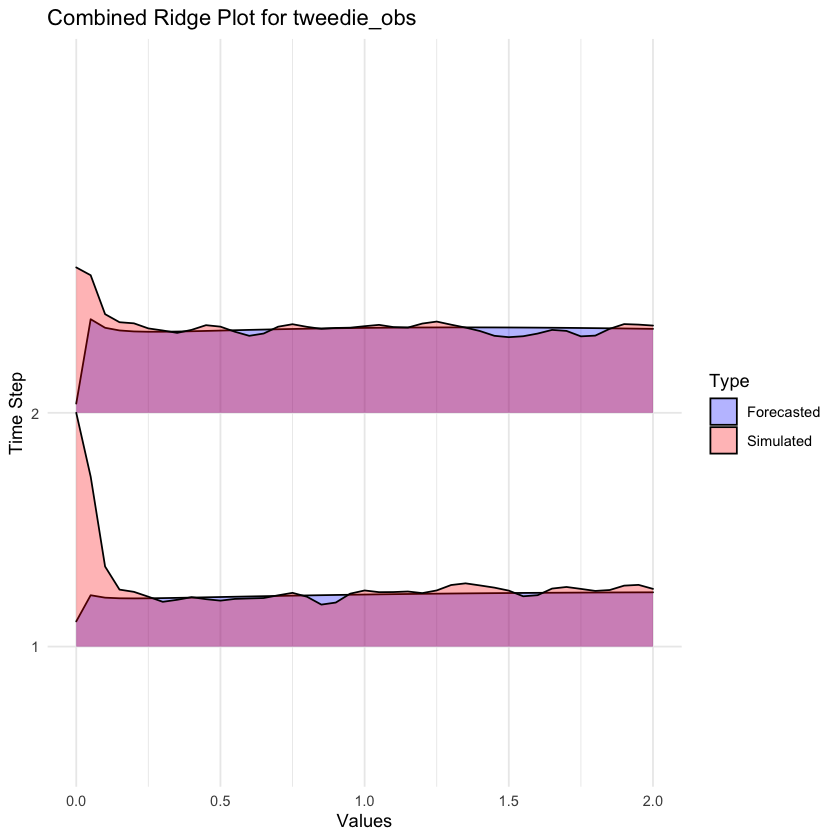

In [86]:
library(ggplot2)
obs <- "tweedie_obs" # Change this to the observation you want to plot
# Prepare data for combined ridge plot
if (!is.null(dim(evaluation_vals[[obs]]))) {
  eval_range <- unique(evaluation_vals[[obs]][1, ])
} else {
  eval_range <- evaluation_vals[[obs]]
}

combined_data <- rbind(
  data.frame(
    x = rep(eval_range, n_forecast),
    time = rep(1:n_forecast, each = length(eval_range)),
    density = as.vector(forecast_dists[[obs]])/max(as.vector(simulated_pdfs[[obs]])),
    type = "Forecasted"
  ),
  data.frame(
    x = rep(eval_range, n_forecast),
    time = rep(1:n_forecast, each = length(eval_range)),
    density = as.vector(simulated_pdfs[[obs]])/max(as.vector(simulated_pdfs[[obs]])),
    type = "Simulated"
  )
)

# Create combined ridge plot
ggplot(combined_data, aes(x = x, y = factor(time), height = density, fill = type)) +
  geom_ridgeline(alpha = 0.3) +
  scale_fill_manual(values = c("Forecasted" = "blue", "Simulated" = "red")) +
  labs(
    title = paste("Combined Ridge Plot for", obs),
    x = "Values",
    y = "Time Step",
    fill = "Type"
  ) +
  theme_minimal() +
  coord_cartesian(ylim = c(1, 3))
